--- Đang xử lý: CarTGMT/CarTGMT/AQUA2_5204_checkin_2020-10-23-9-481sttoguEih.jpg ---
-> Tìm thấy 4 vùng có khả năng là biển số (Đã lọc nhiễu).
 > Đang phân tích ứng viên 0...


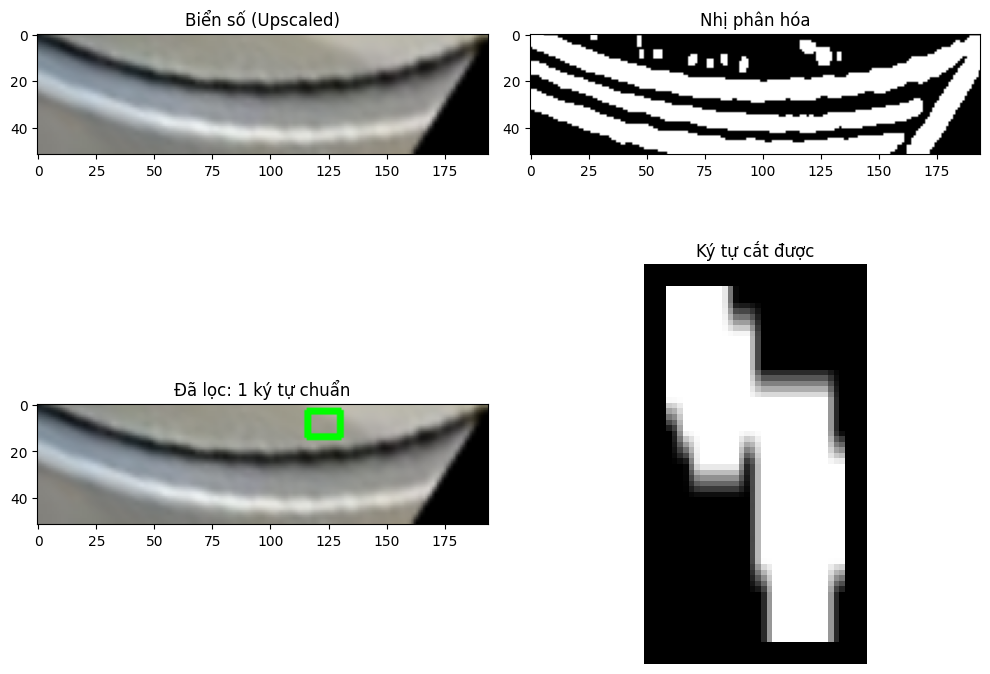

 -> Kết quả: Tách được 1 ký tự sạch.
 > Đang phân tích ứng viên 1...


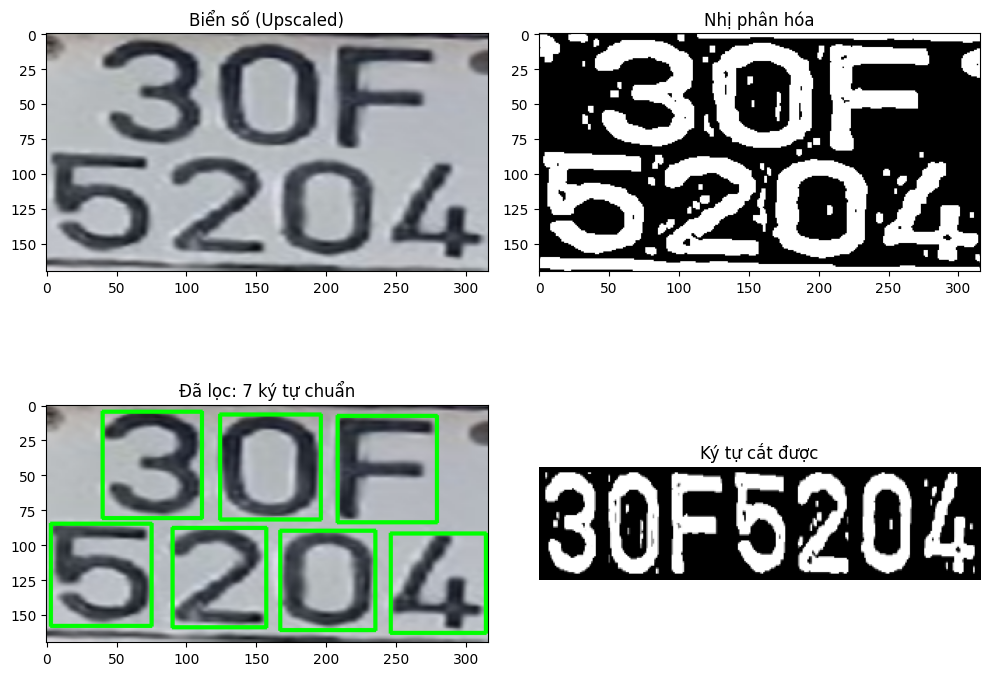

 -> Kết quả: Tách được 7 ký tự sạch.
 > Đang phân tích ứng viên 2...


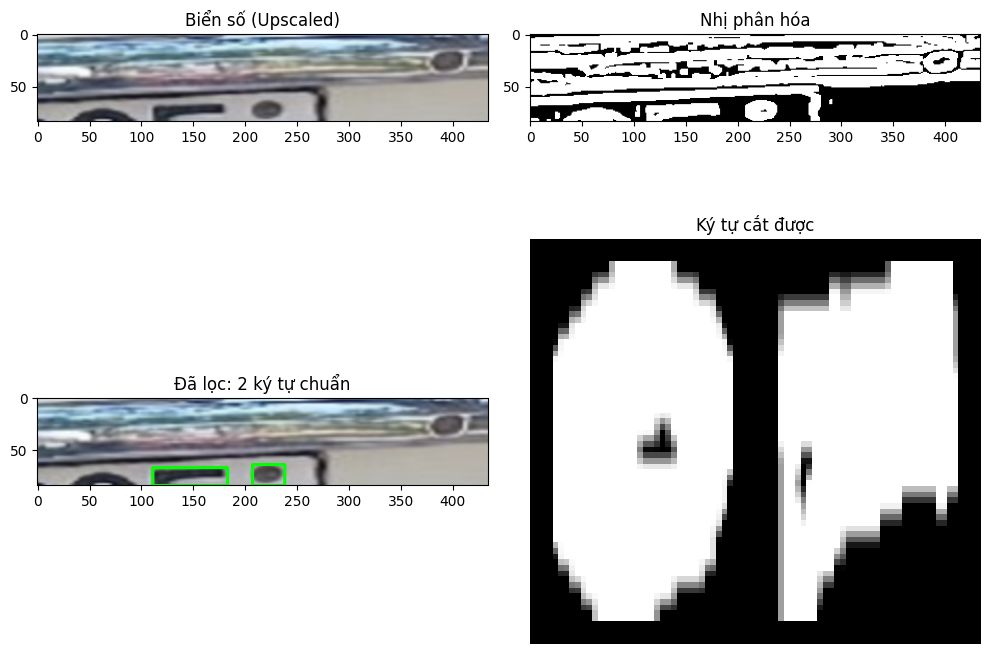

 -> Kết quả: Tách được 2 ký tự sạch.
 > Đang phân tích ứng viên 3...


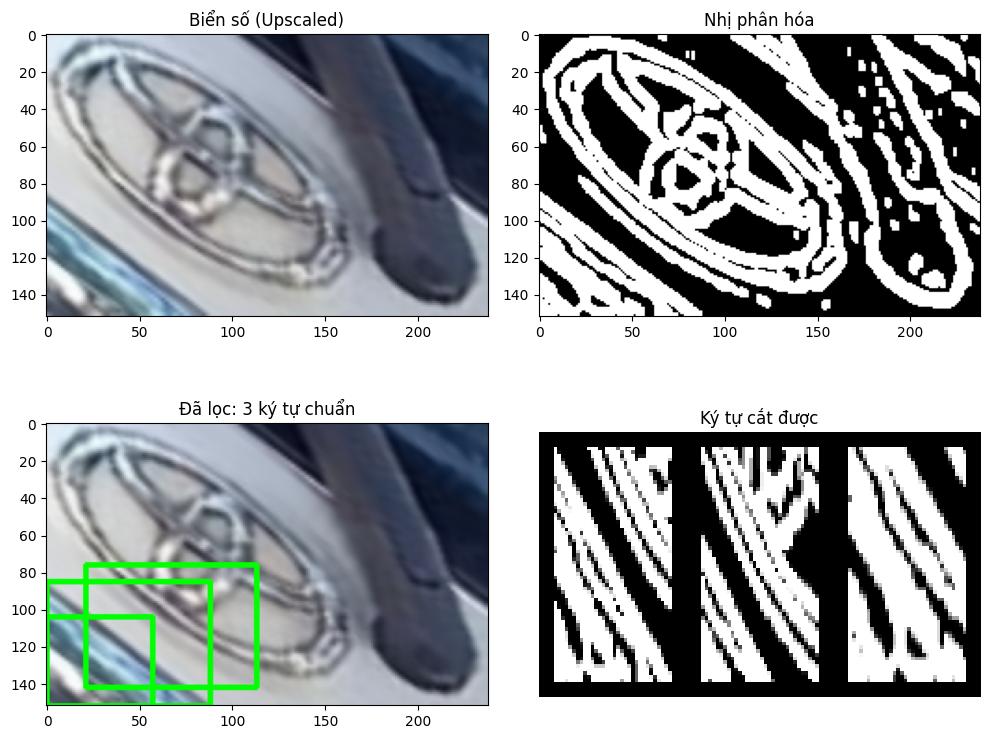

 -> Kết quả: Tách được 3 ký tự sạch.


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

class LicensePlateRecognition:
    def __init__(self, debug=True):
        self.debug = debug

    def order_points(self, pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def four_point_transform(self, image, pts):
        rect = self.order_points(pts)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    def detect_plate(self, image_path):
        """GIAI ĐOẠN 2: Phát hiện biển số (Đã thêm bộ lọc vùng thừa)"""
        img = cv2.imread(image_path)
        if img is None:
            print("Lỗi: Không tìm thấy ảnh input.")
            return None, None

        img = cv2.resize(img, (800, 600))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height, width = img.shape[:2]

        # Tiền xử lý
        blur = cv2.bilateralFilter(gray, 11, 17, 17)
        enhanced = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(blur)

        # Sobel & Threshold
        sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
        sobelx = cv2.convertScaleAbs(sobelx)
        _, thresh = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphology
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
        morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        candidates = []
        
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(c)

            # --- BỘ LỌC 1: LOẠI BỎ NGÀY GIỜ/TIMESTAMP ---
            # Nếu vùng chọn nằm sát đáy ảnh (cách đáy < 5% chiều cao ảnh) -> Bỏ qua
            if y + h > height * 0.95:
                continue

            if area > 1000:
                # Chỉ lấy tỷ lệ biển xe máy (vuông) và ô tô (dài) chuẩn
                # Tỷ lệ biển xe máy ~ 1.4, biển ô tô ~ 4.0
                if (0.8 <= aspect_ratio <= 2.0) or (3.5 <= aspect_ratio <= 5.5):
                    rect = cv2.minAreaRect(c)
                    box = cv2.boxPoints(rect)
                    box = np.int32(box)
                    
                    plate_img = self.four_point_transform(img, np.float32(box))
                    candidates.append(plate_img)

        print(f"-> Tìm thấy {len(candidates)} vùng có khả năng là biển số (Đã lọc nhiễu).")
        return candidates

    def segment_characters(self, plate_img):
        """GIAI ĐOẠN 3: Tách ký tự (Đã tối ưu cho số 1 mỏng)"""
        if plate_img is None: return []

        # 1. Upscale ảnh (quan trọng để giữ chi tiết số 1)
        plate_img = cv2.resize(plate_img, (0, 0), fx=2.0, fy=2.0)
        gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        
        # 2. Adaptive Threshold (Giảm C xuống để nét chữ dày hơn)
        # Block size 19, C=4 (C càng nhỏ thì vùng trắng càng nhiều -> chữ càng dày)
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 19, 4 
        )

        # 3. Dilation dọc (Vertical Dilation) - CHÌA KHÓA ĐỂ CỨU SỐ 1
        # Giúp nối liền các số 1 bị đứt gãy và làm nó dày lên
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 4))
        thresh = cv2.dilate(thresh, kernel_vertical, iterations=1)

        # 4. Tìm Contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        h_plate, w_plate = thresh.shape[:2]
        raw_candidates = []

        # Bước 5: Lọc thô (Raw Filtering)
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            ratio = h / float(w)
            area = cv2.contourArea(c)

            # --- NỚI LỎNG ĐIỀU KIỆN ---
            # Chiều cao: Chấp nhận từ 1/7 đến toàn bộ chiều cao (trừ viền)
            if (h_plate / 7) < h < (h_plate * 0.95):
                # Tỷ lệ: Số 1 có thể rất mỏng, nâng giới hạn ratio lên 10.0
                if 0.2 < ratio < 10.0: 
                    # Diện tích: Hạ ngưỡng xuống 30 để bắt số 1 nhỏ
                    if area > 30: 
                        raw_candidates.append((x, y, w, h))

        # Bước 6: Lọc tinh dựa trên tính thống nhất (Consistency Check)
        if not raw_candidates: return []
        
        # Tính chiều cao trung vị (Median Height) của các ký tự tìm được
        heights = [h for (_, _, _, h) in raw_candidates]
        median_h = np.median(heights) 

        clean_chars = []
        for (x, y, w, h) in raw_candidates:
            # Chỉ giữ lại ký tự có chiều cao xấp xỉ chiều cao trung bình
            # Nới rộng khoảng cho phép từ 0.7-1.3 lên 0.6-1.4 để bắt số 1 bị ngắn
            if 0.6 * median_h < h < 1.4 * median_h:
                clean_chars.append((x, y, w, h))

        # Bước 7: Sắp xếp & Cắt ảnh (Giữ nguyên logic cũ)
        if not clean_chars: return []

        ys = [y for (_, y, _, _) in clean_chars]
        y_threshold = sum(ys) / len(ys)

        row1 = [c for c in clean_chars if c[1] < y_threshold] # Dòng trên
        row2 = [c for c in clean_chars if c[1] >= y_threshold] # Dòng dưới

        row1 = sorted(row1, key=lambda b: b[0])
        row2 = sorted(row2, key=lambda b: b[0])
        sorted_chars = row1 + row2
        
        final_char_imgs = []
        debug_img = plate_img.copy()

        for (x, y, w, h) in sorted_chars:
            # Cắt từ ảnh thresh (ảnh nhị phân) để đưa vào model nhận dạng
            # Hoặc cắt từ ảnh gray nếu muốn giữ chi tiết xám
            char_roi = thresh[y:y+h, x:x+w]
            
            # Resize về kích thước chuẩn (ví dụ 32x64)
            char_roi = cv2.resize(char_roi, (32, 64)) 
            
            # Thêm viền đen để tách biệt hoàn toàn
            char_roi = cv2.copyMakeBorder(char_roi, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=(0, 0, 0))
            
            final_char_imgs.append(char_roi)
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

        if self.debug:
            self.show_debug_segmentation(plate_img, thresh, debug_img, final_char_imgs)

        return final_char_imgs
 
    def show_debug_segmentation(self, original, thresh, boxes, chars):
        plt.figure(figsize=(10, 8))
        plt.subplot(221); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Biển số (Upscaled)")
        plt.subplot(222); plt.imshow(thresh, cmap='gray'); plt.title("Nhị phân hóa")
        plt.subplot(223); plt.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB)); plt.title(f"Đã lọc: {len(chars)} ký tự chuẩn")
        
        if chars:
            h, w = chars[0].shape
            montage = np.zeros((h, w * len(chars)), dtype="uint8")
            for i, c in enumerate(chars):
                montage[:, i*w:(i+1)*w] = c
            plt.subplot(224); plt.imshow(montage, cmap='gray'); plt.title("Ký tự cắt được")
            plt.axis('off')
        
        plt.tight_layout(); plt.show()

    def run(self, image_path):
        print(f"--- Đang xử lý: {image_path} ---")
        potential_plates = self.detect_plate(image_path)
        
        if not potential_plates:
            print("Không tìm thấy biển số.")
            return

        for i, plate in enumerate(potential_plates):
            print(f" > Đang phân tích ứng viên {i}...")
            chars = self.segment_characters(plate)
            print(f" -> Kết quả: Tách được {len(chars)} ký tự sạch.")

if __name__ == "__main__":
    # Thay ảnh của bạn vào đây
    image_path = 'CarTGMT/CarTGMT/AQUA2_5204_checkin_2020-10-23-9-481sttoguEih.jpg' 
    if os.path.exists(image_path):
        LicensePlateRecognition(debug=True).run(image_path)
    else:
        print("File ảnh không tồn tại!")

--- Đang xử lý: CarTGMT/CarTGMT/AQUA2_5204_checkin_2020-10-23-9-481sttoguEih.jpg ---
 > Đang phân tích ứng viên 0...


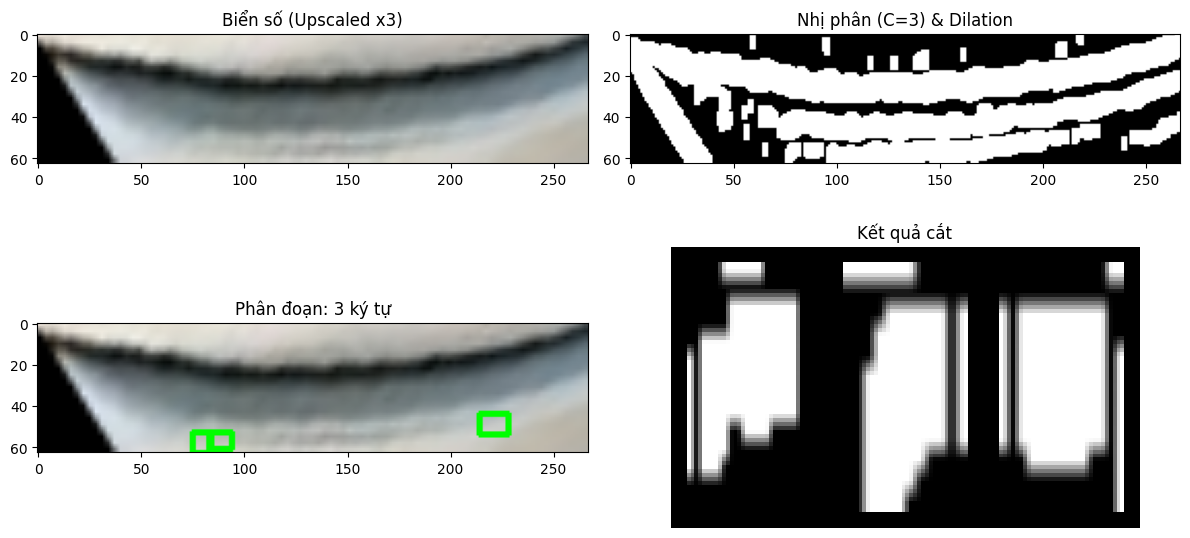

 -> Kết quả: Tách được 3 ký tự.
 > Đang phân tích ứng viên 1...
 -> Kết quả: Tách được 0 ký tự.
 > Đang phân tích ứng viên 2...


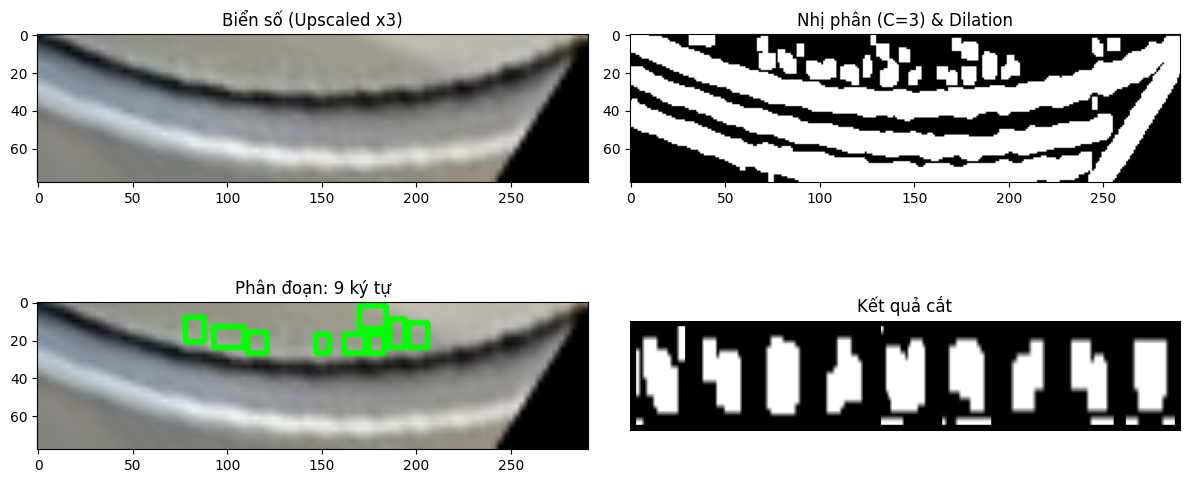

 -> Kết quả: Tách được 9 ký tự.
 > Đang phân tích ứng viên 3...
 -> Kết quả: Tách được 0 ký tự.
 > Đang phân tích ứng viên 4...


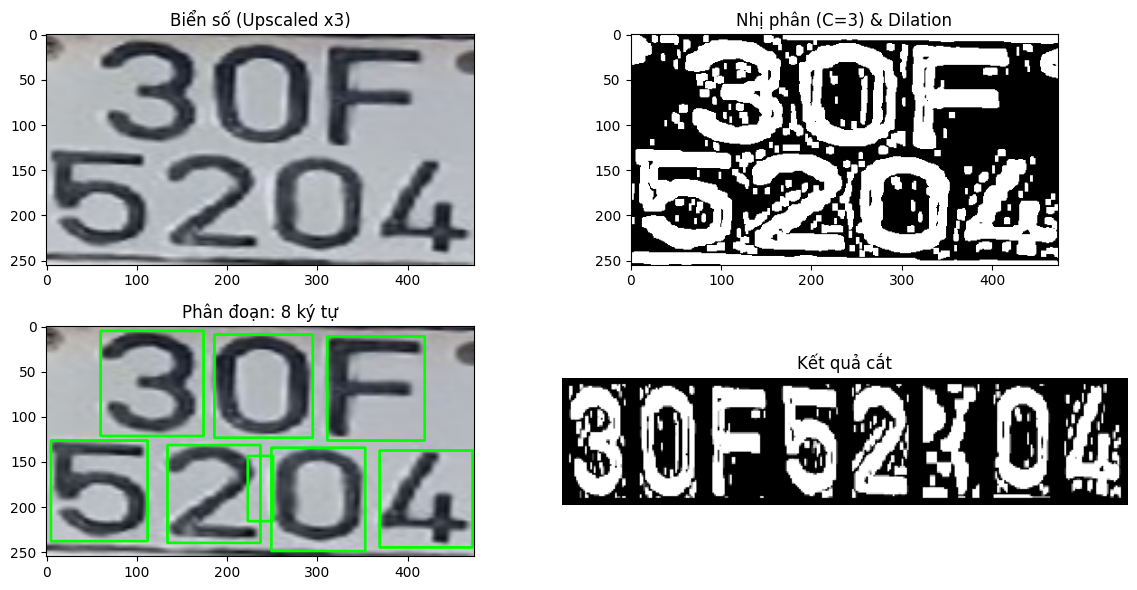

 -> Kết quả: Tách được 8 ký tự.
 > Đang phân tích ứng viên 5...


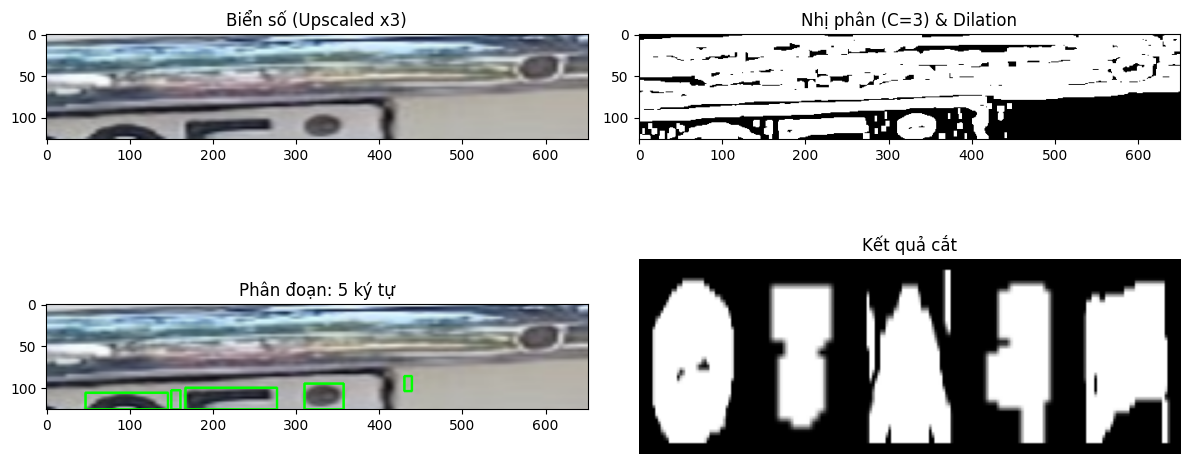

 -> Kết quả: Tách được 5 ký tự.
 > Đang phân tích ứng viên 6...
 -> Kết quả: Tách được 0 ký tự.
 > Đang phân tích ứng viên 7...
 -> Kết quả: Tách được 0 ký tự.


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

class LicensePlateRecognition:
    def __init__(self, debug=True):
        self.debug = debug

    def order_points(self, pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def four_point_transform(self, image, pts):
        rect = self.order_points(pts)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    def detect_plate(self, image_path):
        """GIAI ĐOẠN 2: Phát hiện biển số (ĐÃ FIX: Hạ ngưỡng tỷ lệ xuống 0.5)"""
        img = cv2.imread(image_path)
        if img is None:
            print("Lỗi: Không tìm thấy ảnh input.")
            return []

        img = cv2.resize(img, (800, 600))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        height, width = img.shape[:2]

        # Tiền xử lý
        blur = cv2.bilateralFilter(gray, 11, 17, 17)
        enhanced = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(blur)

        # Sobel & Threshold
        sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=3)
        sobelx = cv2.convertScaleAbs(sobelx)
        _, thresh = cv2.threshold(sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphology
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
        morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        candidates = []
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            aspect_ratio = w / float(h)
            area = cv2.contourArea(c)

            # Bỏ qua vùng timestamp ở đáy ảnh
            if y + h > height * 0.95: continue

            if area > 800:
                # --- FIX LỖI TẠI ĐÂY ---
                # Mở rộng dải tỷ lệ: Từ 0.5 (biển hẹp/cao) đến 7.0 (biển rất dài)
                if (0.5 <= aspect_ratio <= 2.8) or (2.8 < aspect_ratio <= 7.0):
                    rect = cv2.minAreaRect(c)
                    box = cv2.boxPoints(rect)
                    box = np.int32(box)
                    plate_img = self.four_point_transform(img, np.float32(box))
                    candidates.append(plate_img)

        return candidates

    def segment_characters(self, plate_img):
        """GIAI ĐOẠN 3: Tách ký tự (Final Cleaning - Lọc sạch nhiễu 100%)"""
        if plate_img is None: return []

        # 1. Upscale & Tiền xử lý (Giữ nguyên cấu hình 'Robust' để không mất số 1)
        plate_img = cv2.resize(plate_img, (0, 0), fx=3.0, fy=3.0)
        gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        
        # Adaptive Threshold (C=3)
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 19, 3 
        )

        # Dilation dọc & ngang nhẹ
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 6))
        thresh = cv2.dilate(thresh, kernel_vertical, iterations=1)
        kernel_square = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        thresh = cv2.dilate(thresh, kernel_square, iterations=1)

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        h_plate, w_plate = thresh.shape[:2]
        raw_candidates = []

        # 2. Lọc thô (Raw Filtering)
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            ratio = h / float(w)
            area = cv2.contourArea(c)

            # Giữ bộ lọc lỏng để bắt hết mọi khả năng
            if (h_plate / 8) < h < (h_plate * 0.98):
                if 0.15 < ratio < 12.0 and area > 40: 
                    raw_candidates.append((x, y, w, h))

        if not raw_candidates: return []

        # --- BỘ LỌC 1: CHIỀU CAO TRUNG VỊ (MEDIAN HEIGHT FILTER) ---
        # Tính chiều cao trung bình của tất cả các ứng viên tìm được
        heights = [h for (x, y, w, h) in raw_candidates]
        median_h = np.median(heights)
        
        semi_clean = []
        for (x, y, w, h) in raw_candidates:
            # Chỉ giữ lại các vùng có chiều cao sai lệch không quá 40% so với trung bình
            # Giúp loại bỏ thanh sắt (quá cao) hoặc đinh ốc (quá thấp)
            if 0.6 * median_h < h < 1.4 * median_h:
                semi_clean.append((x, y, w, h))
                
        if not semi_clean: return []

        # --- BỘ LỌC 2: KIỂM TRA CẤU TRÚC DÒNG (ROW CONSISTENCY) ---
        # Gom nhóm các ký tự nằm trên cùng một dòng (dựa vào tâm Y)
        cy_list = [y + h/2 for (x, y, w, h) in semi_clean]
        sorted_indices = np.argsort(cy_list) # Sắp xếp theo thứ tự từ trên xuống dưới
        
        clusters = []
        current_cluster = [semi_clean[sorted_indices[0]]]
        last_cy = cy_list[sorted_indices[0]]
        
        # Ngưỡng khoảng cách Y để coi là cùng 1 dòng
        threshold_y = h_plate * 0.15 

        for i in range(1, len(sorted_indices)):
            idx = sorted_indices[i]
            cy = cy_list[idx]
            candidate = semi_clean[idx]
            
            if cy - last_cy < threshold_y:
                current_cluster.append(candidate) # Cùng dòng -> gom vào
            else:
                clusters.append(current_cluster) # Khác dòng -> ngắt cụm cũ
                current_cluster = [candidate]    # Tạo cụm mới
            last_cy = cy
        clusters.append(current_cluster)

        # Chỉ giữ lại các dòng có ít nhất 3 ký tự (Biển số xe luôn >= 3 ký tự/dòng)
        final_chars = []
        for cluster in clusters:
            if len(cluster) >= 3: 
                final_chars.extend(cluster)
        
        # Sắp xếp trái-phải, trên-dưới (Logic cũ)
        if not final_chars: return []

        ys = [y for (_, y, _, _) in final_chars]
        y_threshold = sum(ys) / len(ys)
        row1 = sorted([c for c in final_chars if c[1] < y_threshold], key=lambda b: b[0])
        row2 = sorted([c for c in final_chars if c[1] >= y_threshold], key=lambda b: b[0])
        sorted_chars = row1 + row2
        
        # Cắt ảnh & Hiển thị
        final_char_imgs = []
        debug_img = plate_img.copy()

        for (x, y, w, h) in sorted_chars:
            pad = 2
            roi_y = max(0, y - pad); roi_x = max(0, x - pad)
            roi_h = min(h_plate, h + 2*pad); roi_w = min(w_plate, w + 2*pad)
            
            char_roi = thresh[roi_y : roi_y + roi_h, roi_x : roi_x + roi_w]
            char_roi = cv2.resize(char_roi, (32, 64))
            char_roi = cv2.copyMakeBorder(char_roi, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=(0, 0, 0))
            
            final_char_imgs.append(char_roi)
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

        if self.debug:
            self.show_debug_segmentation(plate_img, thresh, debug_img, final_char_imgs)

        return final_char_imgs

    def show_debug_segmentation(self, original, thresh, boxes, chars):
        plt.figure(figsize=(12, 6))
        plt.subplot(221); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Biển số (Upscaled x3)")
        plt.subplot(222); plt.imshow(thresh, cmap='gray'); plt.title(f"Nhị phân (C=3) & Dilation")
        plt.subplot(223); plt.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB)); plt.title(f"Phân đoạn: {len(chars)} ký tự")
        
        if chars:
            h, w = chars[0].shape
            montage = np.zeros((h, w * len(chars)), dtype="uint8")
            for i, c in enumerate(chars):
                montage[:, i*w:(i+1)*w] = c
            plt.subplot(224); plt.imshow(montage, cmap='gray'); plt.title("Kết quả cắt")
            plt.axis('off')
        plt.tight_layout(); plt.show()

    def run(self, image_path):
        print(f"--- Đang xử lý: {image_path} ---")
        potential_plates = self.detect_plate(image_path)
        
        if not potential_plates:
            print("Không tìm thấy biển số.")
            return

        for i, plate in enumerate(potential_plates):
            print(f" > Đang phân tích ứng viên {i}...")
            chars = self.segment_characters(plate)
            print(f" -> Kết quả: Tách được {len(chars)} ký tự.")

if __name__ == "__main__":
    # Thay ảnh xe máy của bạn vào đây
    image_path = 'CarTGMT/CarTGMT/AQUA2_5204_checkin_2020-10-23-9-481sttoguEih.jpg' 
    if os.path.exists(image_path):
        LicensePlateRecognition(debug=True).run(image_path)
    else:
        print("File ảnh không tồn tại!")